                                               Workshop 7: Maria Balaet, Valentina Giunchiglia and Dragos Gruia

# Topic Modelling on drug use free text data

The aim of this workshop is to introduce you to the application of **natural language processing (NLP)** algorithms to study free text data. NLP is a branch of artificial intelligence that focuses on trying to understand written and spoken text. In this workshop, we will focus specifically on **topic modelling**, which is an unsupervised machine learning method that automatically analyses groups of words to identify clusters of words that belong to the same topic, or theme.

In particular, we will use topic modelling to examine the reasons behind the change in recreational drug use during the early stages of the pandemic. In the morning, we will investigate why some recreational drug users have decided to increase their use, while later in the day we will apply what we learnt to understand why other users decided to decrease their drug use.


The first thing we need to do is to download and import the packages we will need during the lecture, and to change the display settings in order to be able to visualise more rows and columns when printing dataframes. Today, we will work a lot with two new python modules called `gensim` and `nltk`. `Gensim` is one of the most coimmonly used modules for topic modelling in Python, and `nltk` is an NLP Python toolkit.

In [ ]:
pip install gensim nltk

In [2]:
import pandas as pd
import warnings 
import gensim
import nltk
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)

sb.set_theme("talk")
sb.set_style("whitegrid")

Now, let's import the data that we will use during the workshop and let's check them out. As you can see, the dataframe consists of three columns that report the user ids, whether the drug use of participants increased or decreased during the pandemic and the reasons behind this change in format of free text. 

In [4]:
reasons_for_change_dec2020_more = pd.read_csv("Data/Day7_morning.csv")

In [5]:
reasons_for_change_dec2020_more

,user_id,How has your drug use changed due to the pandemic?,Why has your drug use changed during the pandemic?
0,107cee6d-0024-4861-90be-2f467758776c,I am using more,Increase in marijuana use for relaxation/stress relief
1,2feae3b8-ea3b-4750-acec-02418f995199,I am using more,Microdosing psilocybin
2,3a476ba2-6dbb-42d1-b0f5-c877c0f368d8,I am using more,Boredom
3,3f8b0ac6-200f-49b4-b061-70084536d519,I am using more,"I’m bored and have more free time. Also I have found more people that sell shrooms, which is unrelated to the pandemic"
4,4be44530-aeab-4302-bd92-b000b4eae2fb,I am using more,Went to university
...,...,...,...
285,6fbf9bf3-1e5a-4fde-98be-6015accde42b,I am using more,boredom
286,e262433c-094a-4f35-8b6a-0c6689b2185f,I am using more,Boredom
287,8862877f-c12e-4680-8b7f-04657ae97cbd,I am using more,More time at home
288,035a1239-932f-4dc2-9ae8-4ccad6e7be08,I am using more,I'm more bored and frightened when I read the news



---------
### Code here
The column names of the dataframes are quite long and the row names are not really easy to interpret. 

1. Replace the column headers with the names "how" and "why" respectively for "How has your drug use changed due to the pandemic?" and "Why has your drug use changed during the pandemic?". 
2. Set the user ids as row index
3. Since we are analysing only the participants who increased their drug use, the "how" column should have only "I am using more" answers, check that it is the case.
4. Confirm that there are no missing values

In [10]:
## CODE HERE
reasons_for_change_dec2020_more.rename(columns = {'Why has your drug use changed during the pandemic?': "why"}, inplace = True)

--------
Now that we have a better looking dataframe, let's check out the answers in the *why* column.

In [ ]:
reasons_for_change_dec2020_more['why'].to_list()

 By quickly looking at the answers, it appears that one of the main reasons for starting to use more drugs during the pandemic was *boredom*. However, different people express the same concept in slightly different ways. Let's print a few answers. 

In [12]:
print(reasons_for_change_dec2020_more['why'][3], "\n",
      reasons_for_change_dec2020_more['why'][14],"\n",
      reasons_for_change_dec2020_more['why'][34]
     )

I’m bored and have more free time. Also I have found more people that sell shrooms, which is unrelated to the pandemic 
 Boredom/accessibility/situational. I have done E twice during this period, separated by around 3 months, and ket twice, separated by about 4 months, so I'm not concerned about restricting myself, or doing so to excess. 
 Boredom and loneliness 


If you look more carefully, you will notice a few other things: 1) some people wrote boredom with or without capital letters, 2) some answers have empty spaces, 3) other answers have special characters, 4) some words are spelled incorrectly... All these aspects are just few examples of the noise that free text answers have, and that need to be removed before starting any analysis. The data cleaning step in free text analysis is **fundamental**!


In [13]:
print(reasons_for_change_dec2020_more['why'][285], "\n",
      reasons_for_change_dec2020_more['why'][286],"\n",
      reasons_for_change_dec2020_more['why'][281], "\n",
      reasons_for_change_dec2020_more['why'][278], "\n",
      reasons_for_change_dec2020_more['why'][273], "\n",
     )

boredom 
 Boredom  
 / 
 Boredom but stopped.now 
 Bordem 



## Data cleaning of free text


Data cleaning is necessary to remove errors in the data, to reduce the noise to the minimum and to include in the analysis only what is essential. The most important cleaning steps of free-text data are the following:

1. **Turning all letters to lower case:** this is important otherwise words with capital letters will be mistakenly recognised as different compared to the same words without capital letters (e.g. This and this).
2. **Removal of punctuation, special characters and digits**: punctuation creates noise in the data. It cannot be used to make sense of the meaning of a topic because it does not represent words and computer don't know how to interpret it.
3. **Tokenization**: method that consists of separating a piece of text (in this case the answers of each participants) into smaller linguistic units called tokens (in this case words). 
4. **Stop words removal**: method that consists in removing words that are really common in english, but don't provide much information, such as "to", "in" or "when. These words just create noise in the data.
5. **Lemmatization**: process of grouping together the inflected forms of a word so they can be analysed as a single item
6. **Removal of empty answers**

Let's complete these cleaning steps, in order to understand better what they do and why they are important. First, we will turn everything to lower case. 

In [14]:
reasons_for_change_dec2020_more['why'] = reasons_for_change_dec2020_more['why'].str.lower() 

Then, we remove all punctuations (e.g. *,* or *.*), special characters (e.g. *?,/* and *&*) and digits.

In [15]:
reasons_for_change_dec2020_more['why'] = reasons_for_change_dec2020_more['why'].str.replace('[,\.!?/&]', '')
reasons_for_change_dec2020_more['why'] = reasons_for_change_dec2020_more['why'].str.replace('\d+', '')

Now, let's save the free text data into a separate variable, and let's check it out. Were all digits, punctuations, and special characters removed?

In [ ]:
data = reasons_for_change_dec2020_more['why'].to_list()
data

The next step of the data cleaning and preparation is **tokenization**. Tokenization is necessary to make the sentences analysable and understandable for the computer, and consists of splitting each answer of participants into lists of individual words. There is a function in the gensim package that can do this directly, by taking as input each separate answer, called `simple_preprocess`. By providing as argument `deacc=True`, the function removes punctuations if it finds any. In addition, the function removes all words that have less that 2 letters or more than 20. Words with less than 2 letters are usually not really meaningfull, and those with more than 20 are oddly long! They could be just some typing mistakes.

In [17]:
data_words = []
for sentence in data:
    listwords = gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=2, max_len=20)
    data_words.append(listwords)
    
data_words[10]   

['fewer', 'events', 'makes', 'for', 'more', 'exciting', 'evening']

Check different elements in the *data_words* list. Do yo understand how tokenization works?

Now that we have the answers in terms of lists of words, we can do some cleaning on the words themselves. The first thing we are going to do is to remove the stop words, or commonly used words in the English language. Luckily, the *nltk* module has alredy a list of these words that we can simply download.

In [18]:
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english') 
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valentinagiunchiglia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Of course, if you think that other words are too common and should be removed, but they are not in this list, you can easily add them. Adding extra filter is always a good idea. In this way, the noise in the data is reduced even more. Do you have any other words in mind? If you do, add it to the following list.

In [19]:
custom_stop = ['goes','with'] 
finalstop = stop + custom_stop
print(finalstop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Now that we have our final list of stop words, we can remove those words from the list of words of each participants' answers. 

In [20]:
data_words_final = []

for answer in data_words:
    data_words_cleaned = []
    for word in answer:
        if word not in finalstop:
            data_words_cleaned.append(word)
    data_words_final.append(data_words_cleaned)

print("Before:" , data_words[10]  ) 
print("After:" , data_words_final[10]  ) 

Before: ['fewer', 'events', 'makes', 'for', 'more', 'exciting', 'evening']
After: ['fewer', 'events', 'makes', 'exciting', 'evening']


As you can see, the stop words "for" and "more" were removed.

Now, we can complete the final step of the pre-processing, which is the **lemmatization** step. Lemmatization groups together different inflected forms of words, so that they can be analysed as a unique item. For example, it converts the different conjugations of verbs into the inifinite forms (e.g. "swim", "swam" and "swum" would be all converted to "swim"), or turns the plurals of nouns into the singular form. 

In Python, it can be completed with the `WordNetLemmatizer()` method and the `lemmatize` function.

In [21]:
nltk.download('wordnet')

lemma = nltk.stem.wordnet.WordNetLemmatizer()

data_words_lemmatized = []
for answer in data_words_final:
    data_words_cleaned = []
    for word in answer:
        lematized = lemma.lemmatize(word)
        data_words_cleaned.append(lematized)
    data_words_lemmatized.append(data_words_cleaned)

print("Before:" , data_words_final[10]  ) 
print("After:" , data_words_lemmatized[10]  ) 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valentinagiunchiglia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Before: ['fewer', 'events', 'makes', 'exciting', 'evening']
After: ['fewer', 'event', 'make', 'exciting', 'evening']


As you can see, "events" was converted to "event", and "makes" to "make". Check a few other answers to see what changed.

Let's check how many answers we have now

In [22]:
len(data_words_lemmatized)

290

In total we have 290 answers, however, after the cleaning, some of these will be completely empty. This usually happens when participants don't reply properly to the questions, and just write down something random. These answers are of course useless and should be removed. We will save the numbers of the answers that were dropped, because we will need this information later on.

In [55]:
data_words_lemmatized_cleaned = []
dropped_ids = []
for i, answer in enumerate(data_words_lemmatized):
    if answer:
        data_words_lemmatized_cleaned.append(answer)
    else:
        dropped_ids.append(i)
        
    
len(data_words_lemmatized_cleaned)

283

After removing the empty answers, we have now 283 fully cleaned answers that can be used for the analysis.

In [24]:
reasons_for_change_dec2020_more_cleaned=data_words_lemmatized_cleaned

## Topic modelling using LDA

In today's workshop, we will do topic modelling using **Latent Dirichlet Allocation (LDA)**. LDA is the most popular topic modelling method, which aims to find the topics within a body of text based on the words it contains. Let's look at the name of the method and try to understand what each word means:

- **Latent**: indicates that the model discovers the ‘yet-to-be-found’ or hidden topics from the documents.
- **Drichlet**: indicates the two assumptions of LDA - that both the distribution of topics withinin a document and the distribution of words within each topic are Dirichlet distributions (which is a type of probability distribution).
- **Allocation** indicates the distribution of topics in the document.

LDA assumes that the words within a document can be used to determine the topics. LDA assigns each word in a document to different topic, then maps the entire document to a list of topics. Put another way, LDA computes a many-to-many relationship between topics and words, and thus a many-to-many relationship between documents and topics.

[Here](https://proceedings.neurips.cc/paper/2001/file/296472c9542ad4d4788d543508116cbc-Paper.pdf) you can find the original paper, if you are really interested in understanding the method in details (this is not required).

One of the requirements of LDA is to specify the number of topics that should be identified within the set of answers. The number of topics is a user-defined parameter, better called **hyperparamerter**. In machine learning, a hyperparameter is a parameter that is external to the model, that cannot be inferred from the data, and therefore need to be fine-tuned each time depending on the model you are developing and the dataset you are using, in order to find the optimal value.

In case of LDA, one of the best approaches to identify the optimal value for the number of topics is to use the **Coherence Score**. The coherence score specifies whether a certain topic split gives rise to coherent topics. The higher is the score, the more coherent are the topics. Concretely, this score is a mathematical metric that quantifies how words co-occur together in a given topic to ascertain how coherent that topic is. In order to use this score to identify the optimal number of topics, it is necessary to run the LDA analysis with different number of topics and calculate the score for each of them. The number of topics that leads to the highest coherence score will correspond to the optimal number.


Let's start by getting the data in the right format in order to be able to run LDA. The LDA function takes as input two main arguments: 

1. A **dictionary** that has as keys an id number and as values a word (each word is assigned to a different id number)
2. The **corpus** which is essentially the list of answers in a bag-of-words format, that corresponds to (word_id, word_count), where the word id corresponds to the id assigned to the word in the dictionary.

To better understand what these are, let's create them using the *gensin* package.

In [25]:
id2word = gensim.corpora.Dictionary(reasons_for_change_dec2020_more_cleaned)
print(id2word[1])
print(id2word[2])
print(id2word[11])

marijuana
relaxationstress
free


As you can see `id2word` is a dictionary, where each key is a number, and the value of that key is a different word. For example, *id* 1 is assigned to the word *marijuana*.

In [26]:
corpus = []
for answer in reasons_for_change_dec2020_more_cleaned:
    corpus.append(id2word.doc2bow(answer))

print("Answer", reasons_for_change_dec2020_more_cleaned[0])
print("Corpus", corpus[0])

Answer ['increase', 'marijuana', 'use', 'relaxationstress', 'relief']
Corpus [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


As you can see, each word of each answer is converted into (word_id, word_count).

Now that we have the data in the right format, we can define which numbers of topics we want to test to find what the optimal number is. Today, we will try a maximum of 10 topics. Some data might require many more than 10, but the more topics numbers you test, the more time and computational resources you will need.

In [27]:
min_topics = 1
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
topics_range

range(1, 10)

**Let's run LDA with all the potential numbers of topics!**

To be able to do it, we need to complete the following steps:
1. Create a results dictionary where we will store the topic number and coherence score at each iteration
2. Loop over all the potential number of topics
3. Run the LDA model and change the number of topics at each iteration
4. Calculate the coherance score for each topic number
5. Save the coherence score in the results dictionary

Depending on the amount of RAM that your computer has, this step can be more or less slow. To have an overview of how long you still need to wait before the computation is completed, Python has a really nice function and module called `tqdm` that creates progress bars when running for loops.

In [ ]:
pip install tqdm

In [142]:
from tqdm import tqdm 

results = {'Topics_Number': [], "cv_Coherence_avg": []}
    
for n_topics in tqdm(topics_range):
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=n_topics, 
                                                        random_state=100,
                                                        chunksize=100,
                                                        passes=50,
                                                        workers=20,
                                                        iterations=150,
                                                        minimum_probability=0)
                                                                 
    cv_coherence_total = gensim.models.CoherenceModel(model=lda_model, 
                                            texts=reasons_for_change_dec2020_more_cleaned, 
                                            dictionary=id2word).get_coherence()
            
    results['Topics_Number'].append(n_topics)
    results['cv_Coherence_avg'].append(cv_coherence_total)

100%|██████████| 9/9 [01:22<00:00,  9.16s/it]


In [144]:
results_df = pd.DataFrame(results)
results_df

,Topics_Number,cv_Coherence_avg
0,1,0.35
1,2,0.36
2,3,0.37
3,4,0.44
4,5,0.40
5,6,0.42
6,7,0.42
7,8,0.39
8,9,0.42


Great! Now that we have the coherance score for each number of topic, we can create a plot to visualize the results and better see where the peak is

Text(0, 0.5, 'Coherence Score')

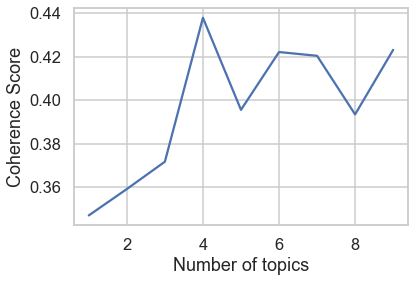

In [153]:
sb.lineplot(x='Topics_Number', y='cv_Coherence_avg', data=pd.DataFrame(results))
plt.xlabel("Number of topics")
plt.ylabel("Coherence Score")

Based on the plot and the results dataframe, the peak is at topic number = 4, which suggests that 4 is the optimal number of topics. However, there is something important to mention here. If you look at the **LdaMulticore** function, there are three arguments that we set for you, which are `passes`, `iterations` and `chunksize`. These three values are also hyperparameters that one should generally fine-tune. `Passes` corresponds to the number of passes through the corpus during training, `chunksize` to the number of documents to be used in each training chunk, and `iterations` to the maximum number of iterations that are completed through the corpus when inferring its topic distribution. Depending on the values set in these three parameters, the results **will change**. 

Try to change those values and see what happens. 

In the end, to properly understand what's the best number of topics is necessary to manually look at the final results, and see whether the identified topics make sense using a more qualitative approach. A combination of a quantitative (e.g. the coherence score) and qualitative approach is usually the best way to go.

Due to time constraints, we will not fine-tune the number of `passes`, `iterations` and `chunksize`. We already provided to you the best values based on previous reserach experiments. Now that we know that 4 is the optimal topic number, let's run LDA using 4 as number of topics.

In [69]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=4, 
                                                    random_state=100,
                                                    chunksize=100,
                                                    passes=50,
                                                    workers=20,
                                                    iterations=150,
                                                    minimum_probability=0)

Let's look at the 4 topics and the top 5 words that represent them using the method `show_topics`

In [70]:
lda_model.show_topics(formatted=False, num_words= 5)

[(0,
  [('boredom', 0.037061803),
   ('cannabis', 0.01557644),
   ('weed', 0.015200648),
   ('nothing', 0.015123372),
   ('lockdown', 0.011541349)]),
 (1,
  [('boredom', 0.07059862),
   ('bored', 0.02425547),
   ('stress', 0.018472293),
   ('something', 0.016428715),
   ('pandemic', 0.014037266)]),
 (2,
  [('time', 0.060700405),
   ('home', 0.027685318),
   ('cannabis', 0.0204383),
   ('le', 0.016971562),
   ('use', 0.015748909)]),
 (3,
  [('cannabis', 0.029807761),
   ('help', 0.023181701),
   ('relax', 0.01960078),
   ('sleep', 0.019266754),
   ('smoking', 0.017234461)])]

As you can see the output of the function is the topic number, and a list of (word, probability) for each topic, where the probability corresponds to the probability of each word for that specific topic. Let's print only the words and ignore the probabilities for a moment.

In [71]:
for idx, topic in lda_model.show_topics(formatted=False, num_words= 10):
    wordskeep = [w[0] for w in topic]
    print(f'Topic: {idx} \nWords: {wordskeep}')


Topic: 0 
Words: ['boredom', 'cannabis', 'weed', 'nothing', 'lockdown', 'else', 'time', 'drug', 'thing', 'due']
Topic: 1 
Words: ['boredom', 'bored', 'stress', 'something', 'pandemic', 'university', 'drug', 'use', 'cannabis', 'friend']
Topic: 2 
Words: ['time', 'home', 'cannabis', 'le', 'use', 'boredom', 'free', 'go', 'smoking', 'lockdown']
Topic: 3 
Words: ['cannabis', 'help', 'relax', 'sleep', 'smoking', 'evening', 'month', 'smoke', 'thought', 'went']


**How would you describe each topic in one sentence?** If you struggle to do it, try to increase the number of words that you print for each topic. Is the topic easier to understand now? Do the topics make sense?

Printing the words is of course useful, but there are better ways to visualise the most relevant words for each topic. One way is through **wordclouds**, which are a visual representation of the probability of words for each topic. The bigger is the word in the wordcloud, the higher is the probability for that word in the topic. To be able to visualise wordclouds, we need to install and import a new package called `wordcloud`.

In [ ]:
!pip install wordcloud

In [80]:
from wordcloud import WordCloud

Now that we have the package, we can start preparing the input to the wordclouds function. We will first check how to create the wordcloud for one topic, and then create a for loop to create wordclouds for all topics at once. The input format of the wordclouds function is a dictionary, where each key is a word, and the value is the probability of that word in the topic. To obtain this dictionary we can use a method called `show_topic`, which returns the words and the probability value for a specific topic. The `topn` parameter specifies how many top words should be selected for each topic.


In [127]:
words_topic = {}
for word, probability in lda_model.show_topic(0, topn = 50): #0 means that we are extracting the words, probability for topic 0
    words_topic[word] = probability
print(words_topic)

{'boredom': 0.037061807, 'cannabis': 0.015576441, 'weed': 0.015200649, 'nothing': 0.015123373, 'lockdown': 0.01154135, 'else': 0.011245428, 'time': 0.011160728, 'drug': 0.011090345, 'thing': 0.009685858, 'due': 0.0096372, 'make': 0.009623565, 'le': 0.009598791, 'home': 0.008164382, 'able': 0.0078239795, 'alcohol': 0.0078059924, 'anxiety': 0.0078013632, 'drink': 0.007799008, 'got': 0.0077912975, 'alone': 0.007789193, 'change': 0.007785903, 'go': 0.0077370326, 'try': 0.0076846867, 'smoke': 0.007317396, 'increased': 0.0071898643, 'way': 0.0068671014, 'use': 0.0065764417, 'escape': 0.0059935013, 'mental': 0.005982688, 'pain': 0.005971896, 'fun': 0.005965125, 'think': 0.005964487, 'problem': 0.0059608864, 'day': 0.0059601897, 'state': 0.005958406, 'get': 0.005956011, 'using': 0.0059540267, 'depression': 0.00594743, 'smoking': 0.0058055543, 'bad': 0.0056752064, 'friend': 0.004710253, 'pandemic': 0.004613275, 'lot': 0.0045347493, 'lack': 0.004480921, 'isolation': 0.004149134, 'made': 0.004146

Great! Now we can initialise the wordcloud function, and then use the method `generate_from_frequencies` to create the wordcloud from the dictionary we prepared.

(-0.5, 399.5, 199.5, -0.5)

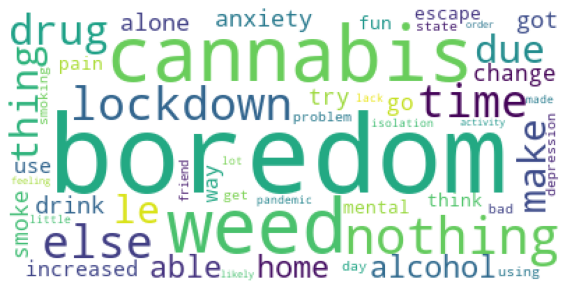

In [173]:
wc = WordCloud(background_color="white", max_words=50)
wc.generate_from_frequencies(words_topic)

_ = plt.figure(figsize = (10, 10))
plt.imshow(wc)
plt.axis("off")

--------
## Code here 

Generate a figure with 4 subplots where each subplot corresponds to the wordcloud for a topic. 


In [125]:
# Code here

    

-----
At this point, thanks to the wordclouds and after printing the words, you should have a general interpretation of the different topics. Now, let's try to use the output of LDA to identify what is the dominant topic in each one of the answers of the participants. This is useful for two main reasons. First, by identifying the dominant topic in each answer we can evaluate the distribution of topics across all answers and see whether a topic was predominant compared to the others. Then, we can check out the 10 answers with the highest dominant topic contribution (or probability) in each topic and assess whether they way we interpreted the meaning of the topics based on the words was appropriate. 

To obtain the probability of each topic for each answer, you can use the `get_document_topics` function. Based on how you defined each topic, do you think it makes sense that the following answer was assigned the highest probability for topic 3? Check a few more.

In [129]:
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
print("Answer", reasons_for_change_dec2020_more_cleaned[10])
print(all_topics[10])

Answer ['fewer', 'event', 'make', 'exciting', 'evening']
[(0, 0.042543437), (1, 0.0424269), (2, 0.041892964), (3, 0.8731367)]


Now that we have this information for each answer, we want to extract it in an easier to view format, which is a dataframe. The aim is to create a dataframe where each row corresponds to an answer, and each column represents the probability of each topic for that answer

In [130]:
all_topics_df = pd.DataFrame(gensim.matutils.corpus2csc(all_topics).T.toarray())
all_topics_df

,0,1,2,3
0,0.87,0.04,0.04,0.04
1,0.08,0.75,0.09,0.08
2,0.13,0.62,0.13,0.13
3,0.45,0.25,0.28,0.02
4,0.08,0.42,0.08,0.42
...,...,...,...,...
278,0.13,0.62,0.13,0.13
279,0.13,0.62,0.13,0.13
280,0.08,0.08,0.75,0.08
281,0.05,0.85,0.05,0.05


Change the column headers with easier to interpret names. They can be simply "Topic_1", "Topic_2", "Topic_3" and "Topic_4", or one word that describes the main theme of the topic based on your interpretation.

In [74]:
## CODE HERE

Finally, to find out the predominant topic for each participant, we just have to identify the topic with the highest probability.

In [145]:
all_topics_df['dominant_topic_contribution'] = all_topics_df.max(axis = 1) 
all_topics_df['dominant_topic'] = np.argmax(all_topics_df.values, axis=1)
all_topics_df

,0,1,2,3,dominant_topic_contribution,dominant_topic
0,0.87,0.04,0.04,0.04,0.87,0
1,0.08,0.75,0.09,0.08,0.75,1
2,0.13,0.62,0.13,0.13,0.62,1
3,0.45,0.25,0.28,0.02,0.45,0
4,0.08,0.42,0.08,0.42,0.42,3
...,...,...,...,...,...,...
278,0.13,0.62,0.13,0.13,0.62,1
279,0.13,0.62,0.13,0.13,0.62,1
280,0.08,0.08,0.75,0.08,0.75,2
281,0.05,0.85,0.05,0.05,0.85,1


In [146]:
all_topics_df["dominant_topic"].value_counts()

1    95
2    70
0    65
3    53
Name: dominant_topic, dtype: int64

As you can see, it appears that the topic number 1 was the most common reason why people increased their use of drugs during the pandemic.

Now that we have the dominant topic for each person, we can check out the 10 answers with the highest dominant topic contribution in each topic. This will allow us to make sure that the interpretation of the topics that we completed before based on the words is actually appropriate. Indeed, it might be easier to interpret a topic by looking at entire answers rather that simple words. To do this, we first have to merge the `all_topics_df` dataframe with the original one containing the actual answers. If you remember, before running LDA, we excluded some answers because at the end of the data cleaning they were completely empty, and we saved the `index`that corresponded to those answers in a variable called `dropped_ids`. Before doing the merging, we will need to remove those answers from the original dataframe, in order to be sure to assign the topic contributions to the respective participants' answers. 

In [147]:
reasons_for_change_dec2020_more.shape, all_topics_df.shape

((290, 3), (283, 6))

As you can see the shape of the dataframes is different because the original data has also the answers that were removed at the end of the data cleaning

In [169]:
answers_df = reasons_for_change_dec2020_more.drop(dropped_ids)
answers_df.head()

,user_id,How has your drug use changed due to the pandemic?,why
0,107cee6d-0024-4861-90be-2f467758776c,I am using more,increase in marijuana use for relaxationstress relief
1,2feae3b8-ea3b-4750-acec-02418f995199,I am using more,microdosing psilocybin
2,3a476ba2-6dbb-42d1-b0f5-c877c0f368d8,I am using more,boredom
3,3f8b0ac6-200f-49b4-b061-70084536d519,I am using more,i’m bored and have more free time also i have found more people that sell shrooms which is unrelated to the pandemic
4,4be44530-aeab-4302-bd92-b000b4eae2fb,I am using more,went to university


In [170]:
answers_df.shape, all_topics_df.shape

((283, 3), (283, 6))

The shapes are now the same! We can move forward with the merging. 

In [171]:
finaldf = pd.concat([all_topics_df.reset_index(), answers_df.reset_index()], axis = 1)
print(finaldf.shape)
finaldf.head()

(283, 11)


,index,0,1,2,3,dominant_topic_contribution,dominant_topic,index,user_id,How has your drug use changed due to the pandemic?,why
0,0,0.87,0.04,0.04,0.04,0.87,0,0,107cee6d-0024-4861-90be-2f467758776c,I am using more,increase in marijuana use for relaxationstress relief
1,1,0.08,0.75,0.09,0.08,0.75,1,1,2feae3b8-ea3b-4750-acec-02418f995199,I am using more,microdosing psilocybin
2,2,0.13,0.62,0.13,0.13,0.62,1,2,3a476ba2-6dbb-42d1-b0f5-c877c0f368d8,I am using more,boredom
3,3,0.45,0.25,0.28,0.02,0.45,0,3,3f8b0ac6-200f-49b4-b061-70084536d519,I am using more,i’m bored and have more free time also i have found more people that sell shrooms which is unrelated to the pandemic
4,4,0.08,0.42,0.08,0.42,0.42,3,4,4be44530-aeab-4302-bd92-b000b4eae2fb,I am using more,went to university


Great! Now we can find out the top n answers with the highest dominant topic contribution for each topic. To do this we have to complete the following steps:
1. Identify the unique dominant topics (e.g. 0, 1, 2, and 3)
2. Create a subset of the dataframe where only the answers assigned to a specific topic are kept
3. Sort the subset dataframe in descending order based on the dominant_topic_contribution value
4. Extract the first n rows - that correspond to the top n answers with the highest dominant topic contributions

The steps are repeated for each topic and the data are stored in a dictionary. The separate dataframes for each topic are merged into a unique one.

In [202]:
n_largest = 10
unique_topics = finaldf['dominant_topic'].unique()
largest_contributors_per_topic = {}
for topic in unique_topics:
    topic_df = finaldf[finaldf['dominant_topic'] == topic]
    largest_contibutors_idx = topic_df['dominant_topic_contribution'].sort_values(ascending = False).iloc[:n_largest].index
    largest_contibutors_df = topic_df.loc[largest_contibutors_idx, :]
    largest_contributors_per_topic[topic] = largest_contibutors_df
    
top_opinions_df_ = pd.concat(largest_contributors_per_topic).reset_index(drop=True)
top_opinions_df_.head(5)

,index,0,1,2,3,dominant_topic_contribution,dominant_topic,index,user_id,How has your drug use changed due to the pandemic?,why
0,51,0.97,0.01,0.01,0.01,0.97,0,51,bc57846a-ed2f-4ba6-8fa5-36d160f309fb,I am using more,i used to drink heavily (+ unitsweek) but have overcome the problem the problem is i essentially replaced it with cannabis and i think lockdown as it affected my mental state significantly has made me more likely to want to use cannabis to relax and escape from problems
1,63,0.97,0.01,0.01,0.01,0.97,0,63,6ded9c48-eeaa-4c97-8a11-d06cfda3b0b3,I am using more,lack of alternative things to do feeling trapped and isolated at home and having decisiondistraction fatigue making it easier to just kill a few hours outside work without having to decide anything or overcome my other mental issues that make it difficult
2,250,0.97,0.01,0.01,0.01,0.97,0,256,f8ce7dd2-8bcc-49ba-bef6-311c9edb02c9,I am using more,i did dry january at the start of and when lockdown occurred i essentially replaced my alcohol reliance with a cannabis reliance normally i'd be able to reduce my cannabis consumption but due to lockdowns i have really struggled there's little else to do
3,122,0.96,0.01,0.01,0.01,0.96,0,124,c070724c-532a-413f-b930-443c7b5f4d54,I am using more,because i haven't been able to go out to bars and pubs and dance so i get drunk at home with my friends and the only way to make it more fun is by taking drugs it makes the monotonous days more fun changes it up a bit
4,156,0.96,0.01,0.01,0.01,0.96,0,160,4c06db2c-5162-4f67-8581-028268909711,I am using more,boredom and anxiety plus not having to stay sober in order to drive places and undertake outside activities a little weed makes being inside with restricted activities a lot more enjoyable


Check the top answers and assess whether your interpretation of the different topics was correct. If it wasn't, updated it accordingly. 

# DAY 7 CHALLENGE - Decrease in drug use and free text analysis 

For today challenge, you will use all of the concepts you learned in this session and apply them to a new dataset. The dataset provides information about why different drug users decided to *decrease* their use of drugs during the pandemic. This information is available in the format of free text answers. The aim of this challenge is to find out what are the most common reasons behind the decrease in drug use, and identify what is the most dominant one. Concretely, you are expected to do the following:

1. Clean the free text data by completing all the following steps: a) turning all letters to lower case, b) removal of punctuation, special characters and digits, c) tokenization, d) stop words removal, e) lemmatization and f) removal of empty answers
2. Identify the optimal number of topics using the coherence score, together with some qualitative analysis. 
3. Run LDA analysis to identify the most common topics, and interpret the meaning of each topic. Idenitify the dominant topics across all participants' answers.
3. **BONUS** (You get extra points if you do it, but you won't lose points if you don't do it): try to use different visualization techniques to better represent your topics and their distributions across the answers of the participants.

The data are available in the csv file called *Day7_challenge.csv*